In [1]:
# coding: utf-8

import numpy as np
from scipy.optimize import minimize, LinearConstraint, BFGS
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs, make_moons, make_circles
from math import copysign as sign
import math

In [12]:
# write here the function you are going to optimize
# note that we are using the optimizer which minimizes the function, so you need to account for this
# returns value of the function calculated based on parameters
"""unfold parameters description below"""
# alphas - 1D array
# y - labels
# x - data
# kernel - callable, defines kernel function to use
def function_to_optimize(alphas, y, x, kernel):
    # left = sum(alphas)
    # right = ai*aj*yi*yj*kernel(xi,xj)
    left = sum(alphas)
    right = 0

    m = len(x)
    for i in range(m):
        for j in range(m):
            right += alphas[i] * alphas[j] * y[i] * y[j] * kernel(x[i], x[j])
    
    return - (left - 0.5 * right)


# linear kernel <x,z>
# returns scalar - output of the kernel
# x, z - vectors / matrices
def linear_kernel(x, z):
    return x.dot(z)


# polynomial kernel (<x,z> + 1)^3 with degree = 3 and c = 1
# returns scalar - output of the kernel
# x, z - vectors / ndarrays
def polynomial_kernel(x, z, c=1, degree=3):
    linear = linear_kernel(x, z)
    return (c + linear) ** degree

def radial_kernel(x, z, gamma=-0.5):
    val = np.dot((x-z), (x-z))
    return math.exp(gamma * val)


# returns array of indices of all support vectors, i.e. those for which alpha > 0
# instead of zero we are using some threshold to account for roundoff errors
# alphas - array of solutions
# thresh - threshold
def find_support_vector_inds(alphas, thresh):
    inds = []
    for _ in range(len(alphas)):
        if alphas[_] > thresh:
            inds.append(_)
    return inds


# calculates w and b after alphas are found. w is calculated only if we are using linear kernel
# w is a vector, b is a scalar
# for calculating b use this formula: b = - (wx_pos + wx_neg)/2
# x_pos and x_neg are positive and negative support vectors lying *exactly* on the margin
# Recall that if sample is on correct side, then alpha = 0, if it's exactly on the margin, then 0 < alpha < C,
# if it's on wrong side, alpha = C. So, chose any of those for which 0 < alpha < C, accounting for roundoff errors (!)
"""unfold parameters description below"""
# alphas - array of solutions
# y - labels
# x - data
# sv_inds - indices of support vectors
# kernel - callable, defines kernel function to use
# thresh - threshold
# C - constant
def find_w_b(alphas, y, x, sv_inds, kernel, thresh, C):
    n = len(x)
    w = np.zeros(shape=(x[0].shape))
    for i in range(n):
        w += x[i] * alphas[i] * y[i]
    
    x_pos = [index for index in sv_inds if (y[index] == 1 and alphas[index] < C - thresh)]
    x_neg = [index for index in sv_inds if (y[index] == -1 and alphas[index] < C - thresh)]
    wx_pos = 0
    wx_neg = 0
    for i in range(n):
        wx_pos += alphas[i] * y[i] * kernel(x[i], x[x_pos[0]])
        wx_neg += alphas[i] * y[i] * kernel(x[i], x[x_neg[0]])

    
    b = - (wx_pos + wx_neg) / 2
    if kernel is linear_kernel:
        return w, b
    return None, b


# make predictions for x_test
# returns array of predictions (1 or -1)
"""unfold parameters description below"""
# alphas - array of solutions
# y - labels
# x - data
# x_test - data for which predictions should be made
# b - calculated b
# sv_inds - indices of support vectors
# kernel - callable, defines kernel function to use
def predict(alphas, y, x, x_test, b, sv_inds, kernel):
    predictions = np.zeros(shape=(len(x_test),))
    # h(x) = sign(sum j=1->S (aj * yj * K(xj, xi)) + b)
    for i in range(len(x_test)):
        summ = 0
        for j in range(len(x)):
            summ += alphas[j] * y[j] * kernel(x[j], x_test[i])
        h = sign(1, summ + b)
        predictions[i] = h
    
    return predictions

In [3]:
# this is the main function which brings it all together
# examine it to understand what's happening in each line
# you only need to finish two lines of code here, describing the constraints
# don't change anything else (!)
def minimize_and_plot(X, Y, kernel, C, thresh):
    n = len(Y)
    # arguments to pass to minimize function
    args = (Y, X, kernel)

    # define the constraints (page 20) as instances of scipy.optimize.LinearConstraint
    # constraints each alpha to be from 0 to C
    alpha_constr = LinearConstraint(np.identity(n), 0, C)  # todo write your code here (one-liner)
    # constraints sum of (alpha * y)
    alpha_y_constr = LinearConstraint(Y, 0, 0)  # todo write your code here (one-liner)

    print("Starting computations...")
     #minimization. we are using ready QP solver 'trust-constr'
    result = minimize(fun=function_to_optimize, method='trust-constr', x0=np.empty(shape=(n,)), jac='2-point',
                      hess=BFGS(exception_strategy='skip_update'), constraints=[alpha_constr, alpha_y_constr],
                      args=args)
   
    # prints the results. If status==0, then the optimizer failed to find the optimal value
    print("status:", result.status)
    print("message:", result.message)

    alphas = result.x
    # indexes of support vectors
    sv_inds = find_support_vector_inds(alphas, thresh)
    print("alphas of support vectors:", '\n', alphas[sv_inds])

    w, b = find_w_b(alphas, Y, X, sv_inds, kernel, thresh, C)

    # create a mesh to plot points and predictions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xrange, yrange = np.meshgrid(np.arange(x_min, x_max, 0.02),
                                 np.arange(y_min, y_max, 0.02))
    # form a grid by taking each point point from x and y range
    grid = np.c_[xrange.ravel(), yrange.ravel()]
    grid = grid.astype(float)
    # make predictions for each point of the grid
    grid_predictions = predict(alphas, Y, X, grid, b, sv_inds, kernel)
    grid_predictions = grid_predictions.reshape(xrange.shape)

    # plot color grid points according to the prediction made for each point
    plt.contourf(xrange, yrange, grid_predictions, cmap='copper', alpha=0.8)
    # plot initial data points
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='autumn')
    # plot support vectors
    plt.scatter(X[sv_inds, 0], X[sv_inds, 1], s=3, c="black")

    if w is not None:  # print lines on which support vectors should reside
        x_plot = np.linspace(x_min, x_max - 0.02, 1000)
        y_plot_1 = (- w[0] * x_plot - b + 1) / w[1]
        y_plot_2 = (- w[0] * x_plot - b - 1) / w[1]
        plt.plot(x_plot, y_plot_1)
        plt.plot(x_plot, y_plot_2)

    plt.title('SVM Results ' + kernel.__name__)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [4]:
# here we assign values for constants
# you can change them when you are testing your solution but when submitting leave it in the original state
n_samples = 20
C_const = 10
threshold = 1e-3

Starting computations...
status: 2
message: `xtol` termination condition is satisfied.
alphas of support vectors: 
 [ 5.32905713 99.99999338 38.39369264 99.99999274 33.06444915]


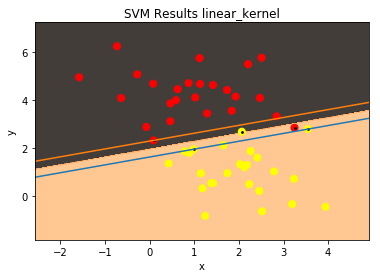

Starting computations...
status: 2
message: `xtol` termination condition is satisfied.
alphas of support vectors: 
 [0.65059372 0.25182848 1.20550267 0.80673587]


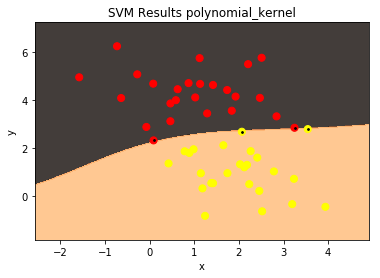

In [3]:
# generating (almost) linearly separable data, replacing 0 labels with -1
X_blob, Y_blob = make_blobs(n_samples=n_samples, centers=2, random_state=0, cluster_std=1.00)
Y_blob[Y_blob == 0] = -1
#plt.scatter(X_blob[:, 0], X_blob[:, 1], c=Y_blob, s=50, cmap='autumn')
#plt.show()

minimize_and_plot(X_blob, Y_blob, linear_kernel, C_const, threshold)  # svm with linear kernel
minimize_and_plot(X_blob, Y_blob, polynomial_kernel, C_const, threshold)  # svm with polynomial kernel

Starting computations...


C:\Users\evger\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


status: 2
message: `xtol` termination condition is satisfied.
alphas of support vectors: 
 [99.99999732 99.99999531 99.99999682 99.99999493 99.99998928 87.91478864
 68.1074701  99.99998928 99.9999972  99.99999532 99.99999543 99.99999321
 99.9999839  56.02248186 99.99998823 99.99998741]


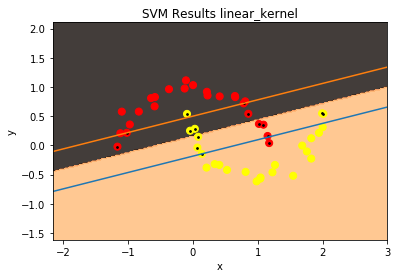

Starting computations...
status: 2
message: `xtol` termination condition is satisfied.
alphas of support vectors: 
 [4.20207697 2.01191199 2.52741414 6.16825566 1.94322049 0.62992643]


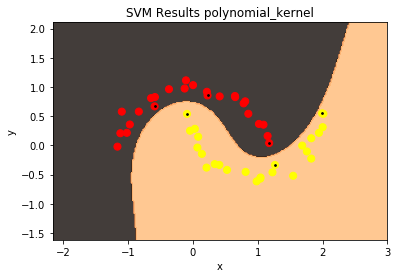

In [4]:
# generating moon-shaped data, replacing 0 labels with -1
X_moon, Y_moon = make_moons(n_samples=n_samples, shuffle=False, noise=0.10, random_state=0)
Y_moon[Y_moon == 0] = -1
#plt.scatter(X_moon[:, 0], X_moon[:, 1], c=Y_moon, s=50, cmap='autumn')
#plt.show()

minimize_and_plot(X_moon, Y_moon, linear_kernel, C_const, threshold)  # svm with linear kernel
minimize_and_plot(X_moon, Y_moon, polynomial_kernel, C_const, threshold)  # svm with polynomial kernel

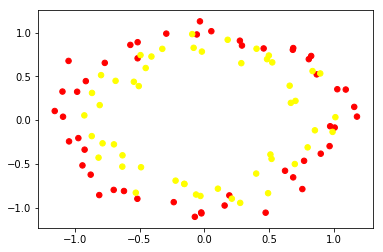

Starting computations...


In [ ]:
# generating moon-shaped data, replacing 0 labels with -1
X_circle, Y_circle = make_circles(n_samples=100, shuffle=False, noise=0.10, random_state=0)
Y_circle[Y_circle == 0] = -1
plt.scatter(X_circle[:, 0], X_circle[:, 1], c=Y_circle, s=30, cmap='autumn')
plt.show()

minimize_and_plot(X_circle, Y_circle, radial_kernel, C_const, threshold)  # svm with linear kernel